In [1]:
import pandas.rpy.common as com
import pandas as pd	
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
%pylab inline
nlme = importr('nlme')
lme4 = importr('lme4')
base = importr('base')

Populating the interactive namespace from numpy and matplotlib


/home/bpinsard/.virtualenvs/prod/local/lib/python2.7/site-packages/matplotlib/__init__.py:784: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/bpinsard/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())
/home/bpinsard/.virtualenvs/prod/local/lib/python2.7/site-packages/pandas/rpy/__init__.py:11: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2. 
See here for a guide on how to port your code to rpy2: http://pandas.pydata.org/pandas-docs/stable/r_interface.html
  FutureWarning)


In [2]:
import sys
sys.path.insert(0,'/home/bpinsard/data/projects/CoRe/')
import core.analysis.lme
data=core.analysis.lme.data_for_lme()

/home/bpinsard/.virtualenvs/prod/local/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/bpinsard/.virtualenvs/prod/local/lib/python2.7/site-packages/nipy/labs/glm/glm.py:7: FutureWarning: Module nipy.labs.utils.routines deprecated, will be removed
  from ..utils import mahalanobis
/home/bpinsard/.virtualenvs/prod/local/lib/python2.7/site-packages/nipype/interfaces/nipy/model.py:18: FutureWarning: Module nipy.labs.glm deprecated, will be removed. Please use nipy.modalities.fmri.glm instead.
  import nipy.labs.glm.glm as GLM
/home/bpinsard/.virtualenvs/prod/local/lib/python2.7/site-packages/numpy/lib/utils.py:95: DeprecationWarning: `scipy.weave` is deprecated, use `weave` instead!
  warnings.warn(depdoc, DeprecationWarn

In [4]:
pdf=pd.DataFrame(data)

In [5]:
del data

In [10]:
sub_pdf = pdf[np.logical_and(np.logical_and(pdf.rt_pre!=np.inf,pdf.sequence=='CoReTSeq'),pdf.task!='mvpa-1-D-Three')]

In [27]:
sub_pdf = pdf[np.logical_or(pdf.task=='Training-TSeq-D_One',pdf.task=='Reactivation-TSeq-D-Two')]

In [29]:
rdf = com.convert_to_r_dataframe(pdf)
rdf.to_csvfile('test_r_file.csv')

rpy2.rinterface.NULL

In [15]:
learn_func = robjects.r("learn_func <- function(learn_start, learn_gain, learn_rate, early_gain, sleep_gain, recons_gain, task, seq_id) learn_start-learn_gain*seq_id^-learn_rate - early_gain*as.numeric(task=='TestBoost-TSeq-D_One') - sleep_gain*as.numeric(task=='Reactivation-TSeq-D-Two') - recons_gain*as.numeric(task=='Testing-TSeq-D-Three')")

In [16]:
model_full=robjects.Formula('rt_pre~learn_func(learn_start, learn_gain, learn_rate, early_gain, sleep_gain, recons_gain, task, seq_id)')


In [17]:
cons_func = robjects.r("cons_func <- function(learn_start, learn_gain, learn_rate, sleep_gain, task, correct_seq_idx) learn_start+learn_gain*correct_seq_idx^-learn_rate - sleep_gain*as.numeric(task=='Reactivation-TSeq-D-Two')")
cons_model = robjects.Formula('model<-rt_pre~cons_func(learn_start, learn_gain, learn_rate, sleep_gain, task, seq_id)')

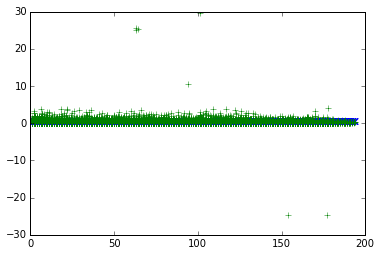

In [18]:
cons_test=cons_func(.5,.1,.1,.1,rdf.rx2('task'),rdf.rx2('seq_id'))
plot(sub_pdf['correct_seq_idx'],com.convert_robj(cons_test),'x')
plot(sub_pdf['correct_seq_idx'],sub_pdf['rt_pre'], '+')

In [33]:
test3=lme4.nlmer(
    robjects.Formula('rt_pre~SSasymp(correct_seq_idx,Asym,xmid,scale)~ Asym | subject_id'),
    start=robjects.ListVector(dict(Asym=.5,xmid=5,scale=1)),
    data=rdf)

Error: is.numeric(nlpars <- start$nlpars) is not TRUE


RRuntimeError: Error: is.numeric(nlpars <- start$nlpars) is not TRUE


In [34]:
test1=nlme.nlme(
    model=cons_model,
    fixed=[
        robjects.Formula('learn_start~1'),
        robjects.Formula('learn_gain~1'),
        robjects.Formula('learn_rate~1'),
        robjects.Formula('sleep_gain~1'),],
    random=[
        robjects.Formula('learn_start~subject_id'),
        robjects.Formula('learn_gain~subject_id'),
        robjects.Formula('learn_rate~subject_id'),
    ],
    group=robjects.Formula('~1'),
    start = [0],
    data=rdf.rx(rdf.rx2('group')=='ReactInt'))

Error in eval(expr, envir, enclos) : object 'subject_id' not found


RRuntimeError: Error in eval(expr, envir, enclos) : object 'subject_id' not found


In [ ]:
test1=nlme.nlme(
    model=model,
    fixed=[

        robjects.Formula('early_gain~1'),
        robjects.Formula('sleep_gain~1'),
        robjects.Formula('recons_gain~1')],
    random=[
        robjects.Formula('learn_start~subject_id'),
        robjects.Formula('learn_gain~subject_id'),
        robjects.Formula('learn_rate~subject_id'),
    ],
    group=robjects.Formula('~subject_id'),
    start = [30,0,0,0,0],
    data=rdf)

In [ ]:
base.summary(test1)